In [1]:
import warnings
warnings.filterwarnings("ignore")
#
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import time
import random
from string import ascii_uppercase as uppr
from itertools import product
import os
#
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr,spearmanr
#
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
SEED = 2021
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
DATA_FOLDER = 'data/'
PLOT_FOLDER = 'plots/'
RERUN_EXPERIMENT = False #if False, logged results will be loaded

In [4]:
NUM_MOTIFS = 8
MOTIFS_SIZE = 8
NODES_PER_GRAPH = 100
TRAIN_GRAPHS_PER_CLASS = 5000
TEST_GRAPHS_PER_CLASS = 500
BASE_DENSITY = .2
MOTIF_PROB = .25

In [5]:
def occurs_nx(graph,motif):
    perfect_match = all([e in graph.edges for e in motif.edges])
    return int(perfect_match)

In [6]:
# feature covariance matrix

def get_cov_matrix_batch(exps,steps):
    mappr = np.array([list(uppr[:NUM_MOTIFS][0::2]),list(uppr[:NUM_MOTIFS][1::2])])
    print(mappr,'\n')
    base_matrix = np.eye(NUM_MOTIFS)
    res = {'0':base_matrix}
    for exp in exps:
        for step in steps:
            if step!=0:
                tmp = np.copy(base_matrix)
                EXP_NAME = exp+'_'+(str(step)[2:] if step<1 else str(step))+\
                                ('00' if step==1 else '0' if step==.5 else '')
                for m1_name in exp:
                    for m2_name in exp:
                        if m1_name!=m2_name:
                            m1_index = uppr[:NUM_MOTIFS].index(m1_name)
                            m2_index = uppr[:NUM_MOTIFS].index(m2_name)
                            tmp[m1_index,m2_index]=step
                res[EXP_NAME] = tmp
    return res

In [7]:
# motif generation

def get_random_connected_motif(num_edges):
    min_nodes = int(np.ceil((1+np.sqrt(1+8*num_edges))/2))
    num_nodes = np.random.randint(min_nodes,num_edges+2)
    while True:
        tmp = nx.empty_graph()
        edges = [(a,b) for a in range(num_nodes) for b in range(a+1,num_nodes)]
        while True:
            try:
                n1,n2 = edges[np.random.randint(len(edges))]
                tmp.add_edge(n1,n2)
                edges.remove((n1,n2))
                if len(tmp.edges)==num_edges:
                    break
            except:
                print('num_nodes',num_nodes,'-->','num_edges',num_edges)
                break
        if nx.is_connected(tmp):
            node_ids = np.random.choice(range(NODES_PER_GRAPH),len(tmp),replace=False)
            raw_motif = nx.relabel.relabel_nodes(tmp,dict(zip(range(NODES_PER_GRAPH),node_ids)))
            all_nodes = sorted(set([a for b in raw_motif.edges for a in b]))
            all_edges = sorted([sorted(edge) for edge in raw_motif.edges])
            result = nx.empty_graph()
            for node in all_nodes:
                result.add_node(node)
            for edge in all_edges:
                result.add_edge(*edge)
            return result
        
def get_disjoint_motif_set(size_list):
    motifs = []
    while len(size_list)>0:
        tmp_motif = get_random_connected_motif(size_list[0])
        if sum([len(set(tmp_motif.edges).intersection(m.edges)) for m in motifs])==0:
            motifs.append(tmp_motif)
            size_list.pop(0)
    return motifs

In [8]:
# synthetic dataset generation

def add_pattern_inplace(graph,motif):
    for edge in motif.edges:
        graph.add_edge(*edge)

def remove_pattern_inplace(graph,motif):
    for edge in motif.edges:
        if edge in graph.edges:
            graph.remove_edge(*edge) 

def make_graph(gzero_density,motifs,class_parity,prob_threshold,cov_mat):
    norm_cov_mat = normalize(cov_mat,norm='l1',axis=1)
    new_graph = nx.erdos_renyi_graph(NODES_PER_GRAPH,gzero_density)
    pvector_raw = [np.random.rand() for _ in range(NUM_MOTIFS)]
    for indx,motif in enumerate(motifs):  
        local_prob = np.dot(pvector_raw,norm_cov_mat[indx])
        if local_prob < prob_threshold:#act
            if indx%2==class_parity:
                add_pattern_inplace(new_graph,motif)
            else:
                remove_pattern_inplace(new_graph,motif)
    return new_graph

def make_synth_dataset(graphs_per_class,gzero_density,motifs,prob_threshold,cov_mat):
    graphs_A = [make_graph(gzero_density,motifs,0,prob_threshold,cov_mat) for _ in range(graphs_per_class)]
    graphs_B = [make_graph(gzero_density,motifs,1,prob_threshold,cov_mat) for _ in range(graphs_per_class)]
    return graphs_A+graphs_B,[0]*graphs_per_class+[1]*graphs_per_class

In [9]:
# pseudo-vif

def pseudo_vif_split(graphs,motifs):
    bin_feat = np.array([[occurs_nx(graph,motif) for motif in motifs] for graph in graphs])
    pseudo_vif_vector = []
    for indx,motif in enumerate(motifs):
        local_copy = bin_feat.copy()
        local_labels = local_copy[:,indx]#[np.random.randint(2) for _ in local_copy[:,indx]]#
        local_feats = np.delete(local_copy, indx, 1)
        model = LogisticRegression()
        local_pred = cross_val_predict(model,local_feats, local_labels,cv=10,method='predict_proba')
        rocauc = roc_auc_score(local_labels, local_pred[:,1])
        pseudo_vif = 1./(1-(2*rocauc-1)+np.finfo(np.float).eps)
        pseudo_vif_vector.append(np.round(pseudo_vif,2))
    return np.array([np.round(x,3) if x<=100 else 'inf' for x in pseudo_vif_vector])

def get_true_covmat(graphs,motifs):
    bin_feat = np.array([[occurs_nx(graph,motif) for motif in motifs] for graph in graphs])
    return np.round(np.cov(bin_feat,rowvar=False),3)

In [10]:
# black-box

class GConvNodeID(tf.keras.layers.Layer):
    def __init__(self,num_feat,num_out,activation):#W has shape (nodes,1)
        super(GConvNodeID,self).__init__()
        self.W = tf.Variable(tf.keras.initializers.GlorotUniform(seed=None)(shape=(num_feat,num_out)))
        self.activation = activation
    def call(self,A,X):
        XW = tf.einsum('bij,jk->bik',X,self.W)
        AXW = tf.einsum('bij,bjk->bik',A,XW)
        return self.activation(AXW)
    
def param_get_gconvnet(nodes_per_graph,dr1=.45,dr2=.45,num_neurons=32,activ='tanh',lr=.0001,loss='mse'):
    attr_input = tf.keras.Input(shape=(nodes_per_graph,nodes_per_graph))
    adjm_input = tf.keras.Input(shape=(nodes_per_graph,nodes_per_graph))
    activ = tf.nn.relu if activ=='relu' else tf.nn.tanh if activ=='tanh' else None
    #
    drop1 = tf.keras.layers.Dropout(dr1)(attr_input)
    gc1 = GConvNodeID(nodes_per_graph,num_neurons, activation=activ)(adjm_input,drop1)
    drop2 = tf.keras.layers.Dropout(dr1)(gc1)
    gc2 = GConvNodeID(num_neurons,num_neurons, activation=activ)(adjm_input,drop2)
    drop3 = tf.keras.layers.Dropout(dr1)(gc2)
    gc3 = GConvNodeID(num_neurons,num_neurons, activation=activ)(adjm_input,drop3)
    conc = tf.concat([gc1,gc2,gc3], axis=-1)
    conv1d =  tf.keras.layers.Conv1D(filters=num_neurons, kernel_size=5, strides=1)(conc)
    flat = tf.keras.layers.Flatten()(conv1d)
    dense1 = tf.keras.layers.Dense(units=128, activation=activ)(flat)#was relu
    dropf = tf.keras.layers.Dropout(dr2)(dense1)
    dense2 = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)(dropf)
    #
    gcnv = tf.keras.Model(inputs=[attr_input,adjm_input], outputs=dense2)
    gcnv.compile(optimizer=Adam(lr=lr), loss=loss)
    #
    return gcnv

In [11]:
# adjacency matrix management and lattice generation

def occurs_adjm(graph_adjm,edge_motif):
    return int((np.array([graph_adjm[x,y] for (x,y) in edge_motif])).all())

def normalise_adjm(adjm):
    adjm = np.array(adjm)
    n_batch, n_row, n_col = adjm.shape
    adjm = tf.add(np.eye(n_row).astype(np.float32),adjm)
    weights_row = tf.tensordot(adjm,tf.ones(n_col),axes=1)
    weights_col = tf.tensordot(tf.transpose(adjm,perm=[0,2,1]),tf.ones(n_row),axes=1)
    diag_row = tf.math.divide_no_nan(1.,tf.pow(weights_row, 0.5))
    diag_col = tf.math.divide_no_nan(1.,tf.pow(weights_col, 0.5))
    tmp = tf.multiply(adjm,tf.expand_dims(diag_col,axis=1))
    Anorm = tf.multiply(tf.expand_dims(diag_row,axis=2),tmp)
    return Anorm

def mask_binary_toggle_edgelist(graph_adjm,edge_motifs,motifs_to_mask,occurring):
    adjm_clone = np.copy(graph_adjm)
    to_remove = [(em,tm,oc) for (em,tm,oc) in zip(edge_motifs,motifs_to_mask,occurring) if tm==1 and oc==1]
    for (edgex,edgey) in [a for b in [x[0] for x in to_remove] for a in b]:
        adjm_clone[edgex,edgey] = 0
        adjm_clone[edgey,edgex] = 0
    to_add = [(em,tm,oc) for (em,tm,oc) in zip(edge_motifs,motifs_to_mask,occurring) if tm==1 and oc==0]
    for (edgex,edgey) in [a for b in [x[0] for x in to_add] for a in b]:
        adjm_clone[edgex,edgey] = 1
        adjm_clone[edgey,edgex] = 1
    return adjm_clone


def get_batch_lattice(model,dummy_attr,graph_dataset,motifs):
    edge_motifs = [list(m.edges) for m in motifs]
    occurring = [[occurs_adjm(g,em) for em in edge_motifs] for g in graph_dataset]
    lattice_nodes = {}
    for motifs_to_mask in product([0, 1], repeat=len(motifs)):#FIX - minus one??
        masked_adjms = [mask_binary_toggle_edgelist(g,edge_motifs,motifs_to_mask,occ) \
                        for g,occ in zip(graph_dataset,occurring)]
        masked_datapoints = normalise_adjm(np.array(masked_adjms))
        scores = model.predict([dummy_attr,np.array(masked_datapoints)]).T[0]
        lattice_nodes[motifs_to_mask] = scores
    return lattice_nodes

In [12]:
# lattice-based marginalisations

def pascaline(n):
    "pascaline(5) -> [1, 4, 6, 4, 1]"
    n -= 1
    line = [1]
    for k in range(max(n,0)):             
        line.append(line[k]*(n-k)//(k+1))             
    return line

def get_marginal(lattice,binary_code,position):
    key_nope = tuple((*binary_code[:position],0,*binary_code[position:]))
    key_with = tuple((*binary_code[:position],1,*binary_code[position:]))
    return lattice[key_nope]-lattice[key_with]

def get_batch_shaps(lattice):
    num_motifs = len(list(lattice.keys())[0])
    num_graphs = len(list(lattice.values())[0])
    pascal = pascaline(num_motifs)
    edge_iterator = list(product([0, 1], repeat=num_motifs-1))
    num_edges = len(edge_iterator)
    depths = [min(sum(x),num_motifs-1-sum(x)) for x in edge_iterator]
    coef = [1./num_motifs/pascal[sum(code)] for code in edge_iterator]
    shap_tensor = np.zeros((num_edges,num_motifs,num_graphs))
    for motif_index in range(num_motifs):
        for edge_index,edge in enumerate(edge_iterator):
            shap_tensor[edge_index,motif_index,:] = get_marginal(lattice,edge,motif_index)
    return depths,coef,shap_tensor

In [13]:
# core method

def graphshap(exp_name,covmat,motifs,verbose=True):
    try:
        t = time.time()
        for k in range(1,len(motifs)):
            assert(set(motifs[k].edges).intersection(set(motifs[k-1].edges))==set([]))
        train_graphs,train_labels = make_synth_dataset(TRAIN_GRAPHS_PER_CLASS,BASE_DENSITY,motifs,MOTIF_PROB,covmat)
        test_graphs,test_labels = make_synth_dataset(TEST_GRAPHS_PER_CLASS,BASE_DENSITY,motifs,MOTIF_PROB,covmat)
        bin_feat = np.array([[occurs_nx(graph,motif) for motif in motifs] for graph in test_graphs])
        pseudo_vif = pseudo_vif_split(test_graphs,motifs)
        true_covmat = get_true_covmat(test_graphs,motifs)
        print('\tsynthgen',int(time.time()-t),'s') if verbose else None
        #
        t = time.time()
        train_dummy_feats = np.array([np.eye(NODES_PER_GRAPH).astype(np.float32)]*len(train_graphs))
        train_raw_adjs = [nx.to_numpy_array(g).astype(np.float32) for g in train_graphs]
        train_norm_adjs = normalise_adjm(train_raw_adjs)
        test_dummy_feats = np.array([np.eye(NODES_PER_GRAPH).astype(np.float32)]*len(test_graphs))
        test_raw_adjs = [nx.to_numpy_array(g).astype(np.float32) for g in test_graphs]
        test_norm_adjs = normalise_adjm(test_raw_adjs)
        print('\tdataset',int(time.time()-t),'s') if verbose else None 
        #
        t = time.time()
        gcnv = param_get_gconvnet(NODES_PER_GRAPH)
        escb = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5, restore_best_weights=True)
        hist = gcnv.fit([train_dummy_feats,train_norm_adjs],np.array(train_labels), \
                validation_data=([test_dummy_feats,test_norm_adjs], np.array(test_labels)),\
                epochs=100, callbacks=[escb], verbose=0, shuffle=True)
        pred = gcnv.predict([test_dummy_feats,test_norm_adjs]).T[0]
        valid = (sum(pred[:TEST_GRAPHS_PER_CLASS]<.5)+sum(pred[TEST_GRAPHS_PER_CLASS:]>.5))\
                                                                    /(2*TEST_GRAPHS_PER_CLASS)
        print('\ttrained model',int(time.time()-t),'s') if verbose else None
        #
        t = time.time()
        batch_lattice = get_batch_lattice(gcnv,test_dummy_feats,test_norm_adjs,motifs)
        depths,coef,shaps_tensor = get_batch_shaps(batch_lattice)
        print('\tglobal shaps',int(time.time()-t),'s')  if verbose else None
        res_dict = {'exp_name':exp_name,'motifs':motifs,'pre_covmat':covmat,
            'test_raw_adjs':test_raw_adjs,'test_norm_adjs':test_norm_adjs,'test_labels':test_labels,
            'pseudo_vif':pseudo_vif,'post_covmat':true_covmat,'bin_feat':bin_feat,
            'valid':valid,'depths':depths,'coef':coef,'shaps_tensor':shaps_tensor}
        return gcnv,hist,res_dict
    except Exception as e:
        print(e)
        return None,None,{'valid':-1}

In [14]:
def run_batch(EXP_PREFIX,experiments):
    motifs = get_disjoint_motif_set([MOTIFS_SIZE]*NUM_MOTIFS)
    pickle.dump(motifs,open(DATA_FOLDER+EXP_PREFIX+'_motifs','wb'))
    for expname,cov in experiments.items():
        EXP_NAME = EXP_PREFIX+'_'+expname
        print(EXP_NAME)
        failcount = 0
        while True:
            gcnv,hist,res_dict = graphshap(EXP_NAME,cov,motifs,verbose=True)
            print('\t',res_dict['valid'],end=' ')
            if res_dict['valid']>.8:
                print('OK')
                pickle.dump(res_dict,open(DATA_FOLDER+EXP_NAME,'wb'))
                gcnv.save('data/net_'+EXP_NAME)
                break
            else:
                failcount+=1
                if failcount==20:
                    print('failed')
                    break

In [15]:
# depth-based comparator

def nrm(x):
    x1 = x-min(x)
    x2 = x1/max(x1)
    return x2

def crunch_layered_sum(exp_name, fcomparison):
    res = []
    num_motifs = experiments[exp_name]['shaps_tensor'].shape[1]
    num_graphs = experiments[exp_name]['shaps_tensor'].shape[2]
    depths = [min(sum(x),num_motifs-1-sum(x)) for x in list(product([0, 1], repeat=num_motifs-1))]
    coeff = experiments[exp_name]['coef']
    raw = experiments[exp_name]['shaps_tensor']
    composed_total = np.multiply(raw,np.array(coeff)[:, np.newaxis, np.newaxis])
    compressed_total = np.sum(composed_total,axis=0)
    for depth in range(max(depths)+1):
        mask = (np.array(depths)<=depth).astype(int)
        composed_masked = np.multiply(composed_total,np.array(mask)[:, np.newaxis, np.newaxis])
        compressed_masked = np.sum(composed_masked,axis=0)
        rank_cfr = [fcomparison(nrm(compressed_masked[:,indx]),nrm(compressed_total[:,indx])) \
                    for indx in range(num_graphs)]
        res.append(rank_cfr)
    return res

In [16]:
def plot_boxplots(data,exp_names):
    plt.figure(figsize=(10,3))
    for exp_index,exp_name in enumerate(exp_names):
        for depth in range(4):
            ax = plt.gca()
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_facecolor('whitesmoke')
            plt.subplot(1,4,depth+1)
            c = ['orangered','limegreen','dodgerblue'][exp_index]
            for k in [.9,.92,.94,.96,.98,1]:
                plt.axhline(k,color='white',linewidth=.5,zorder=0)
            plt.boxplot(data[exp_name][depth],positions=[exp_index],\
                        showfliers=False,widths=[.8],patch_artist=True,
                        boxprops=dict(facecolor='whitesmoke', color=c),whiskerprops=dict(color=c),
                        capprops=dict(color=c),medianprops=dict(color=c))
            plt.ylim(bottom=.9,top=1.01)
            plt.title('depth-'+str(depth+1))
            if depth>0:
                plt.yticks([])
            plt.xticks([],[])
    plt.subplot(1,4,1)
    plt.ylabel('Pearson correlation')
    plt.tight_layout()

In [17]:
EXP_PREFIX = 'exp64'
exp_covmat = get_cov_matrix_batch(exps = ['AC','ACE'],steps = [0,.5,1])

if RERUN_EXPERIMENT:   
    run_batch(EXP_PREFIX,exp_covmat)
    
experiments = {}
for EXP_NAME in exp_covmat.keys():
    experiments[EXP_NAME] = pickle.load(open(DATA_FOLDER+EXP_PREFIX+'_'+EXP_NAME,'rb'))

[['A' 'C' 'E' 'G']
 ['B' 'D' 'F' 'H']] 



In [18]:
fcomparison = lambda x,y:pearsonr(x,y)[0]
data = {x:crunch_layered_sum(x, fcomparison) for x in exp_covmat.keys()}

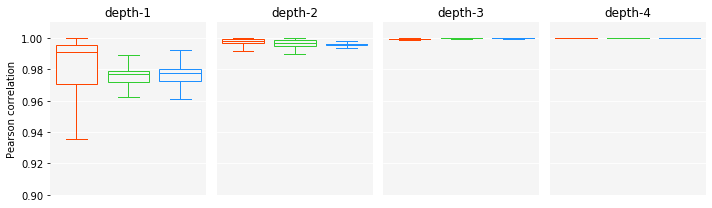

In [19]:
plot_boxplots(data,['0','AC_50','AC_100'])
plt.savefig(PLOT_FOLDER+'fig6a_pairs.pdf')

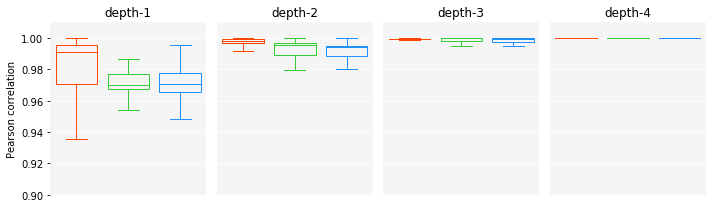

In [20]:
plot_boxplots(data,['0','ACE_50','ACE_100'])
plt.savefig(PLOT_FOLDER+'fig6b_triplets.pdf')